In [1]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("pcaMethods")

In [1]:
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1015. Fire Sufficient Similarity/P1015.3. Analyses/P1015.3.3. Cluster Analysis/Output'
cur_date = '040525'

library(readxl)
library(tidyverse)
library(reshape2)
library(factoextra)
library(pcaMethods)
library(gridExtra)
library(ggrepel)
library(RColorBrewer)
library(cowplot)
library(pheatmap)

# reading in file
full_df = data.frame(read_excel("Input/Processed_Data_040525.xlsx")) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setd

In [2]:
head(full_df)

,HAWC_ID,Metric,Data,Study,Class,DTXSID,Name,Avg_Value
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,1298351,Volume,TRAP,Gunawardena et al. 2012,Metal,Cr,Cr,2.878885e+01
2,1298351,Volume,TRAP,Gunawardena et al. 2012,Metal,Cu,Cu,1.330890e+01
3,1063102,Volume,WS,Nielsen et al. 1992,PAH,DTXSID9020409,Dibenzo(ah)anthracene,6.364081e+04
4,1298351,Volume,TRAP,Gunawardena et al. 2012,PAH,DTXSID5023902,Benzo(a)anthracene,6.022207e-01
5,1298351,Volume,TRAP,Gunawardena et al. 2012,PAH,DTXSID0022432,Chrysene,5.903525e-01
6,1298351,Volume,TRAP,Gunawardena et al. 2012,PAH,DTXSID6024254,Phenanthrene,8.999617e-01


This analysis will use PCA to explore if chemical and metal concentrations of control, WS, and WF samples are similar using PCA.

In [3]:
# will run PCA on each class, so the df will be split
split_df = full_df %>%
    #mutate(HAWC_ID = ifelse(HAWC_ID < 3, Study, HAWC_ID)) %>% 
    group_by(Metric, Class) %>%
    group_split


metal_vol_df = split_df[[1]]
pah_vol_df = split_df[[2]]
voc_vol_df = split_df[[3]]
metal_weight_df = split_df[[4]]
#pah_weight_df = split_df[[5]]

head(metal_vol_df)

HAWC_ID,Metric,Data,Study,Class,DTXSID,Name,Avg_Value
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1298351,Volume,TRAP,Gunawardena et al. 2012,Metal,Cr,Cr,28.78885
1298351,Volume,TRAP,Gunawardena et al. 2012,Metal,Cu,Cu,13.30890
USEPA,Volume,TRAP,USEPA,Metal,Cu,Cu,NA
1070627,Volume,WF,Siregar et al. 2022,Metal,As,As,1.55000
1070627,Volume,WF,Siregar et al. 2022,Metal,Ca,Ca,982.65000
1070627,Volume,WF,Siregar et al. 2022,Metal,Cd,Cd,5.45000


In [4]:
# casting wide
wider_metal_vol_df = metal_vol_df %>%
    # creating sample ids
    unite("SampleID", c(colnames(metal_vol_df)[c(1,3,5)]), remove = FALSE) %>%
    select(-Name) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Avg_Value") %>%
    column_to_rownames(var = "SampleID")
# wider_pah_vol_df = pah_vol_df %>%
#     unite("SampleID", c(colnames(pah_vol_df)[c(1,3,5)]), remove = FALSE) %>%
#     select(-Name) %>%
#     pivot_wider(names_from = "DTXSID", values_from = "Avg_Value") %>%
#     column_to_rownames(var = "SampleID")
# wider_voc_vol_df = voc_vol_df %>%
#     unite("SampleID", c(colnames(voc_vol_df)[c(1,3,5)]), remove = FALSE) %>%
#     select(-Name) %>%
#     pivot_wider(names_from = "DTXSID", values_from = "Avg_Value") %>%
#     column_to_rownames(var = "SampleID")

# wider_metal_weight_df = metal_weight_df %>%
#     unite("SampleID", c(colnames(metal_weight_df)[c(1,3,5)]), remove = FALSE) %>%
#     select(-Name) %>%
#     pivot_wider(names_from = "DTXSID", values_from = "Avg_Value") %>%
#     column_to_rownames(var = "SampleID")
# wider_metal_vol_df = volume_df %>%
#     filter(Chemical_Class == 'Metal') %>%
#     # creating sample ids
#     unite("SampleID", c(colnames(volume_df)[c(1,8,6,5)]), remove = FALSE) %>%
#     pivot_wider(names_from = "DTXSID", values_from = "Value") #%>%
#     #column_to_rownames(var = "SampleID")

head(wider_metal_vol_df)

,HAWC_ID,Metric,Data,Study,Class,Cr,Cu,As,Ca,Cd,⋯,Ag,Ga,Nb,Rb,Zr,Se,Sb,B,Be,Hg
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1298351_TRAP_Metal,1298351,Volume,TRAP,Gunawardena et al. 2012,Metal,28.78885,13.3089,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
USEPA_TRAP_Metal,USEPA,Volume,TRAP,USEPA,Metal,3.91325,NA,0.1805,NA,0.0945,⋯,NA,NA,NA,NA,NA,2.52,2.13775,NA,0.0105,NA
1070627_WF_Metal,1070627,Volume,WF,Siregar et al. 2022,Metal,NA,NA,1.5500,982.6500,5.4500,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1263480_WS_Metal,1263480,Volume,WS,Burnet et al. 1990,Metal,NA,11187.5000,NA,374250.0000,1833.3333,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1263484_WS_Metal,1263484,Volume,WS,Leese et al. 1989,Metal,600.00000,NA,NA,61230.0000,3480.0000,⋯,2330,NA,NA,NA,NA,NA,NA,NA,NA,NA
1289878_WF_Metal,1289878,Volume,WF,Robinson et al. 2004,Metal,NA,NA,NA,692.0833,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# Principal Component Analysis (PCA)

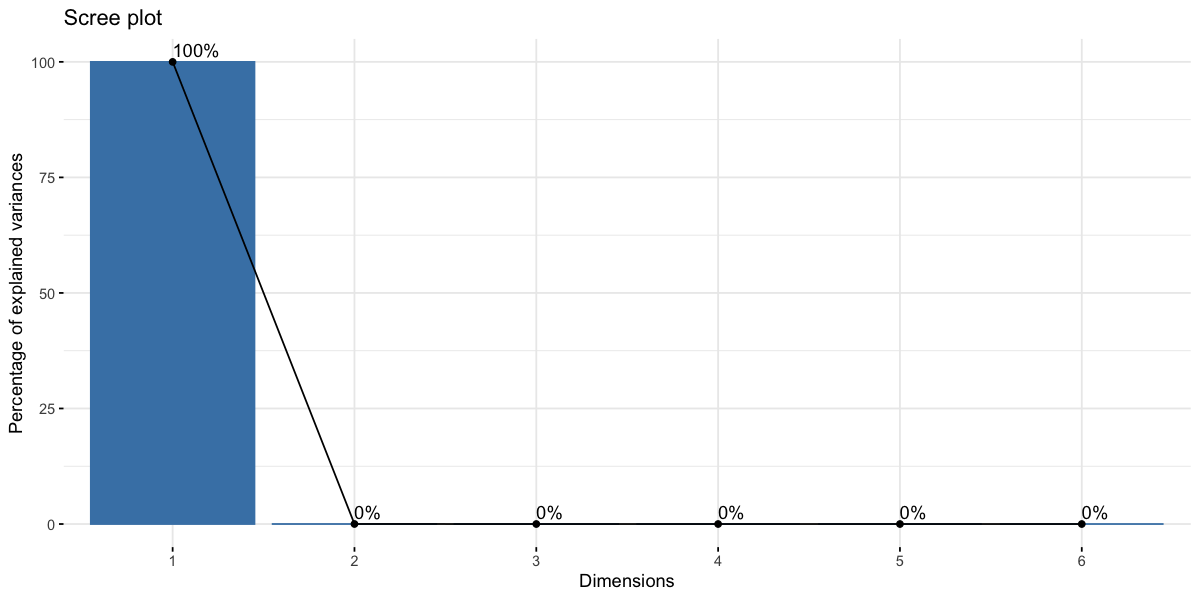

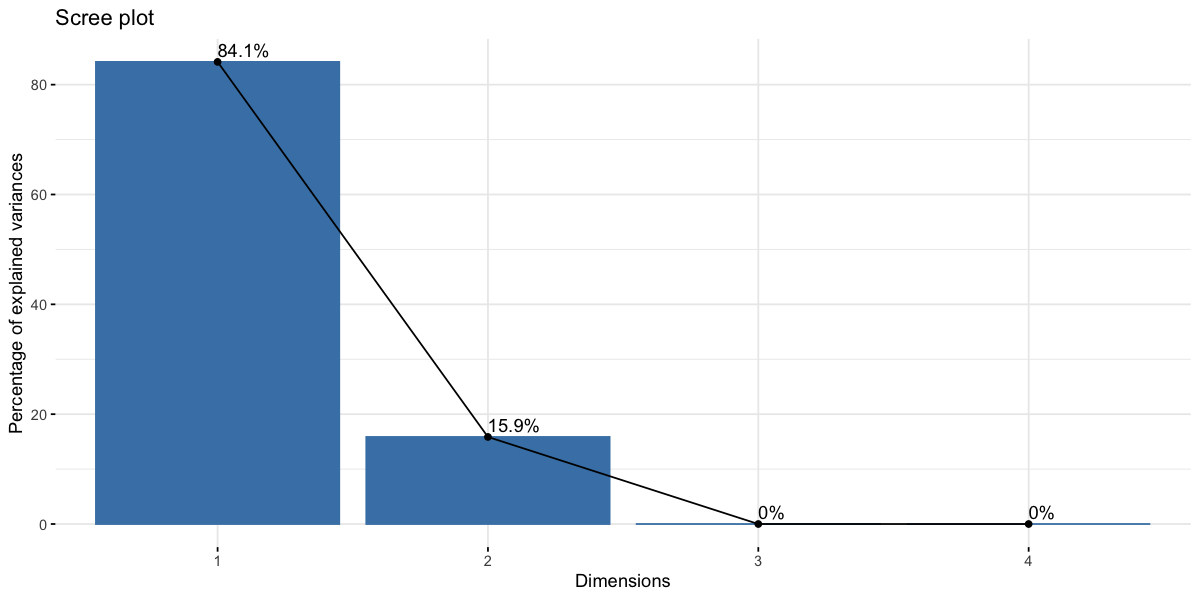

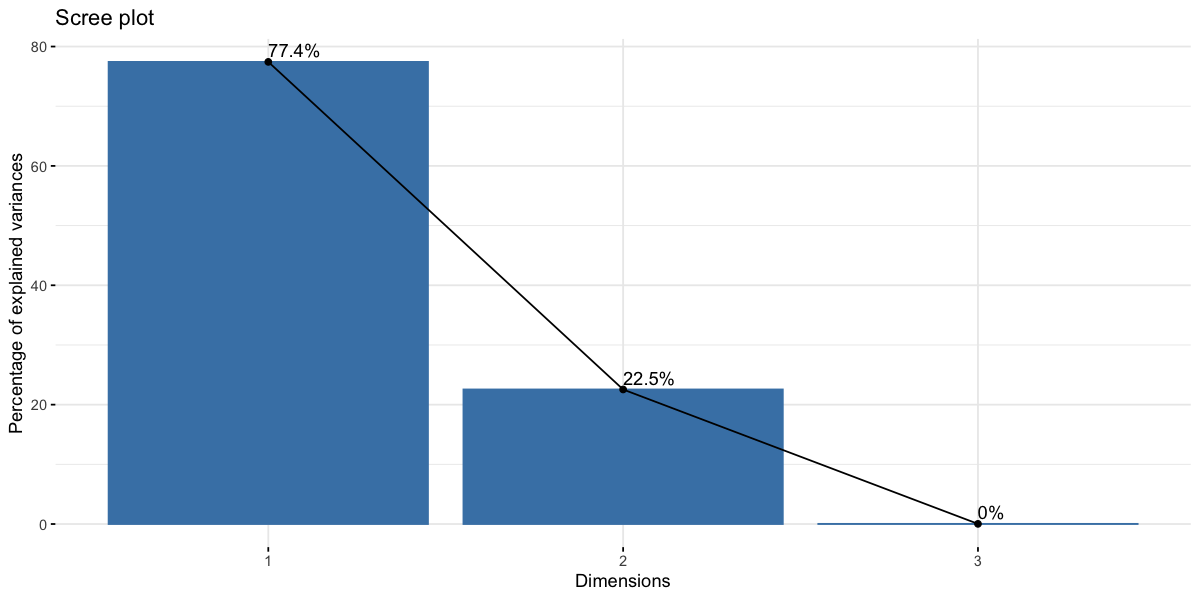

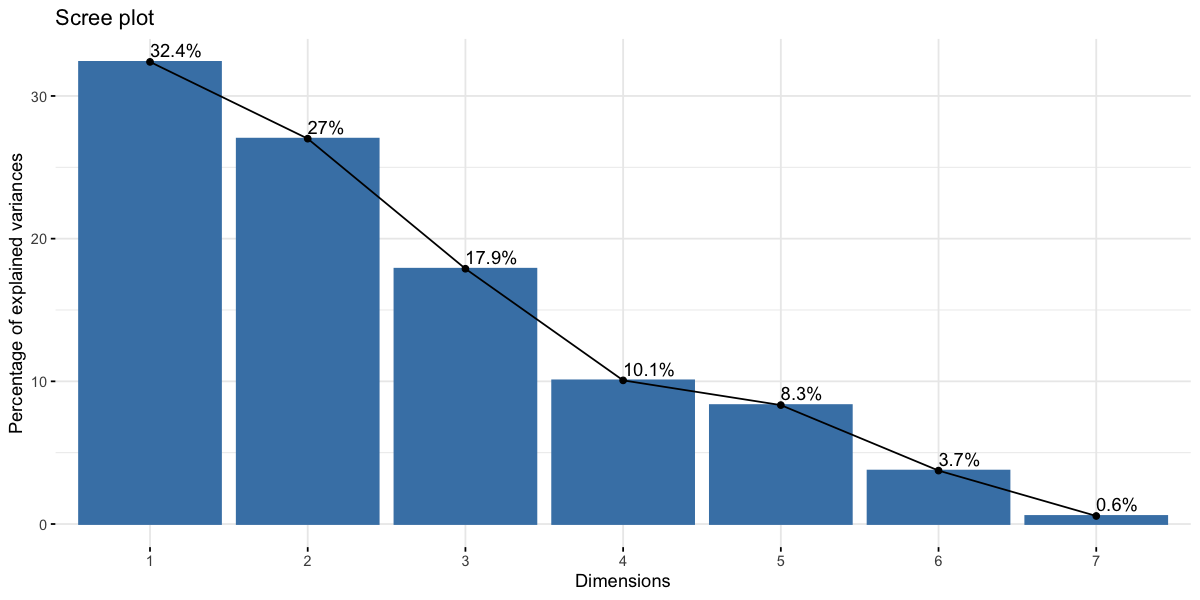

In [6]:
# setting seed for reproducibility
set.seed(12)

# running pca 
metal_vol_pca = prcomp(wider_metal_vol_df[,c(6:ncol(wider_metal_vol_df))], center = TRUE, scale = TRUE)
pah_vol_pca = prcomp(wider_pah_vol_df[,c(6:ncol(wider_pah_vol_df))], center = TRUE, scale = TRUE)
voc_vol_pca = prcomp(wider_voc_vol_df[,c(6:ncol(wider_voc_vol_df))], center = TRUE, scale = TRUE)
metal_weight_pca = prcomp(wider_metal_weight_df[,c(6:ncol(wider_metal_weight_df))], center = TRUE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(metal_vol_pca, addlabels = TRUE)
fviz_eig(pah_vol_pca, addlabels = TRUE)
fviz_eig(voc_vol_pca, addlabels = TRUE)
fviz_eig(metal_weight_pca, addlabels = TRUE)
#fviz_eig(cytokine_pca, addlabels = TRUE)

The standard way to detect outliers in genetics is the criterion of being “more than 6 standard deviations away from the mean”. [source](https://privefl.github.io/blog/detecting-outlier-samples-in-pca/)

In [7]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA sample outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
metal_vol_outliers = outlier_detection(metal_vol_pca)
pah_vol_outliers = outlier_detection(pah_vol_pca)
voc_vol_outliers = outlier_detection(voc_vol_pca) 
metal_weight_outliers = outlier_detection(metal_weight_pca) 

In [8]:
# getting length
length(metal_vol_outliers)
length(pah_vol_outliers)
length(voc_vol_outliers)
length(metal_weight_outliers)

[1] 0

[1] 0

[1] 0

[1] 0

There were no outliers.

In [9]:
# creating 1 df with eigenvectors, normalized values, condensate, burn condition data??
metal_vol_pca_df = data.frame(metal_vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
pah_vol_pca_df = data.frame(pah_vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
voc_vol_pca_df = data.frame(voc_vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
metal_weight_pca_df = data.frame(metal_weight_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")  

more_data_df = rbind(wider_metal_vol_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID"), 
                         wider_pah_vol_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID"), 
                         wider_voc_vol_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID"), 
                         wider_metal_weight_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID")) 

full_eigenvector_df = inner_join(rbind(metal_vol_pca_df, pah_vol_pca_df,
                                       voc_vol_pca_df, metal_weight_pca_df), 
                                             more_data_df) %>%
 # cleaning variable names here
    mutate(Data = ifelse(Data == "WS", "Woodsmoke",
                                  ifelse(Data == "WF", "Wildfire",
                                      ifelse(Data == "Diesel", "Diesel Exhaust", Data))))

head(full_eigenvector_df)

Joining with `by = join_by(SampleID)`


,SampleID,PC1,PC2,HAWC_ID,Metric,Data,Study,Class
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,USEPA_TRAP_Metal,-0.6013203,-0.009964770,USEPA,Volume,TRAP,USEPA,Metal
2,266987_WS_Metal,-0.5849551,0.015916079,266987,Volume,Woodsmoke,Seagrave 2005,Metal
3,452289_WS_Metal,-0.5997580,-0.008306673,452289,Volume,Woodsmoke,Rabha 2018,Metal
4,885041_WS_Metal,-0.6000430,-0.007582500,885041,Volume,Woodsmoke,Ihantola et al. 2020,Metal
5,993956_WS_Metal,-0.6007849,-0.009046279,993956,Volume,Woodsmoke,Ihantola et al. 2022,Metal
6,1263480_WS_Metal,-0.5641361,0.046152088,1263480,Volume,Woodsmoke,Burnet et al. 1990,Metal


In [10]:
# getting the default ggplot colors
gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

# calling fn 
cols = gg_color_hue(4)

# getting color palette
palette_colors = brewer.pal(7, "OrRd")

In [11]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
vol1 = ggplot() + 
  geom_point(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'Metal'), aes(x = PC1, y = PC2, color = Data, shape = Data),
             size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'Metal', PC1 > 7.5), 
                  aes(x = PC1, y = PC2, color = Data, label = HAWC_ID), size = 5, show.legend = FALSE) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  ggtitle('Metal') + 
  labs(x = 'Dimension 1 (100%)', y = 'Dimension 2 (0%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c(cols[2:3], palette_colors[c(5)], cols[4]))

In [12]:
vol2 = ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'PAH'), 
       aes(x = PC1, y = PC2, color = Data, shape = Data)) + 
  geom_point(size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'PAH', PC1 > -0.1), 
                  aes(x = PC1, y = PC2, color = Data, label = HAWC_ID), size = 5, show.legend = FALSE) +

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  ggtitle('PAH') +
  labs(x = 'Dimension 1 (84.1%)', y = 'Dimension 2 (15.9%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c(cols[2:3], palette_colors[c(5)], cols[4])) 

In [13]:
vol3 = ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'VOC'), 
       aes(x = PC1, y = PC2, color = Data, shape = Data)) + 
  geom_point(size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'VOC', PC1 > 5), 
                  aes(x = PC1, y = PC2, color = Data, label = HAWC_ID), size = 5, show.legend = FALSE) +

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  ggtitle('VOC') +
  labs(x = 'Dimension 1 (77.4%)', y = 'Dimension 2 (22.5%)') + #changing axis labels 

  scale_color_manual(name = "Sample Type",
                      values = c(cols[3], palette_colors[c(5)], cols[4])) +
  scale_shape_manual(name = "Sample Type",
                     values = c(17,15,3))

## Volume PCA Plot

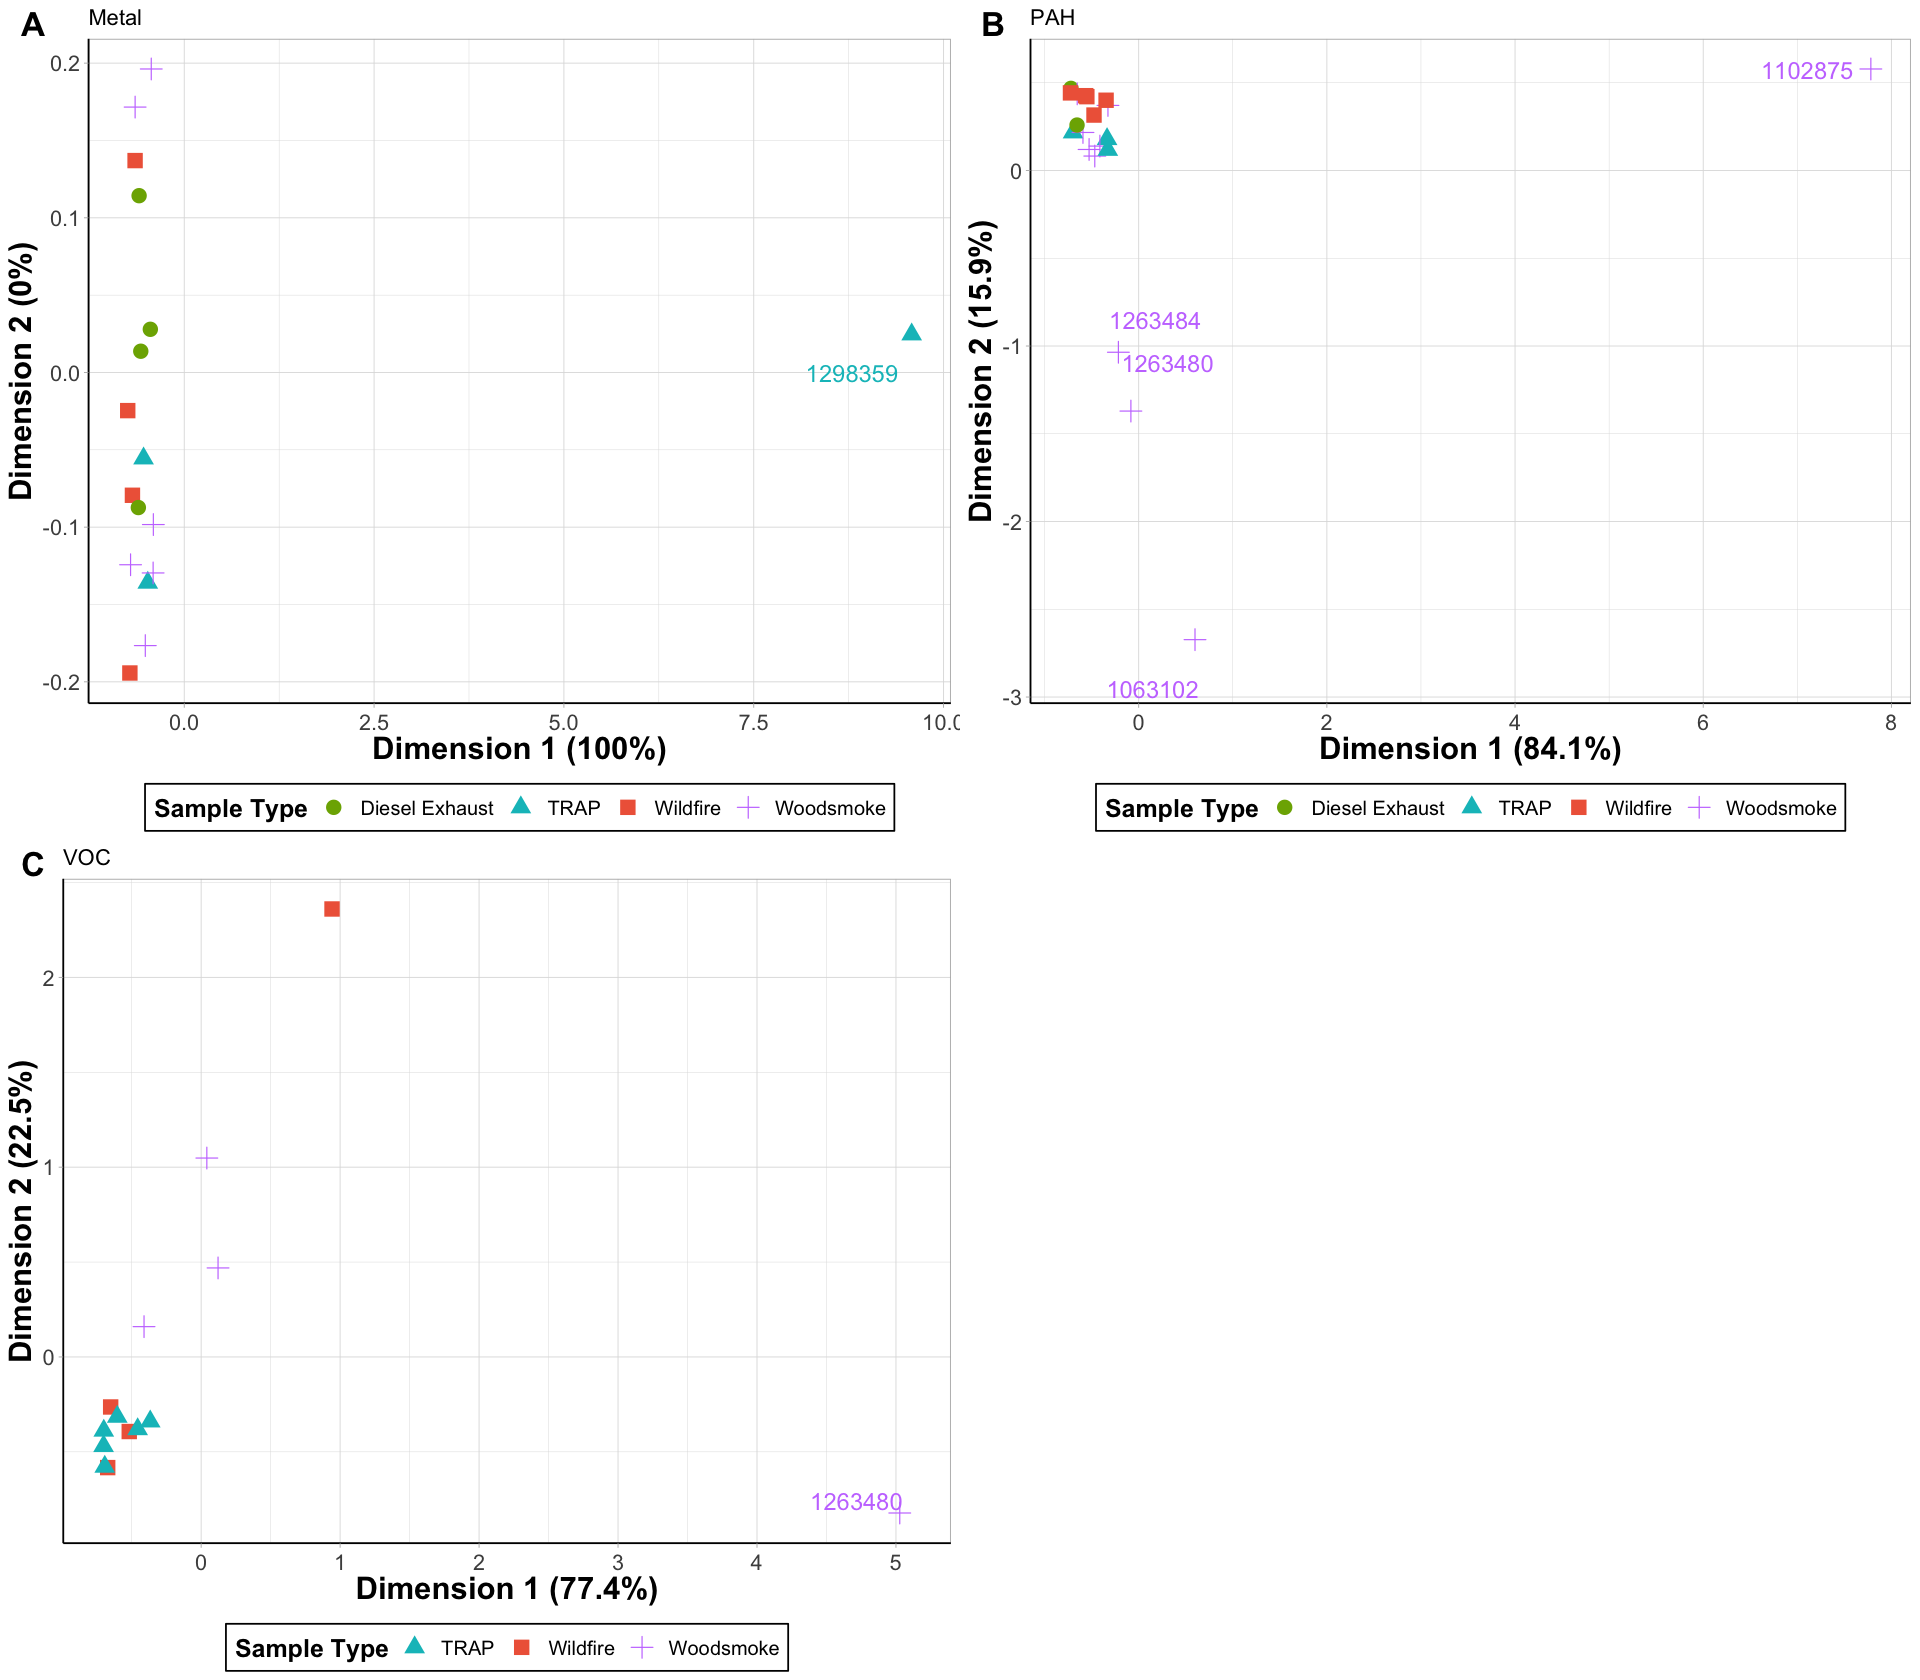

In [14]:
options(repr.plot.width=16, repr.plot.height=14) #changing size
vol_fig = plot_grid(vol1, vol2, vol3, nrow = 2,
                            # adding labels, changing size their size and position
                            labels = "AUTO", label_size = 20, label_x = 0.01, label_y = 1)
vol_fig

## Weight PCA Plot

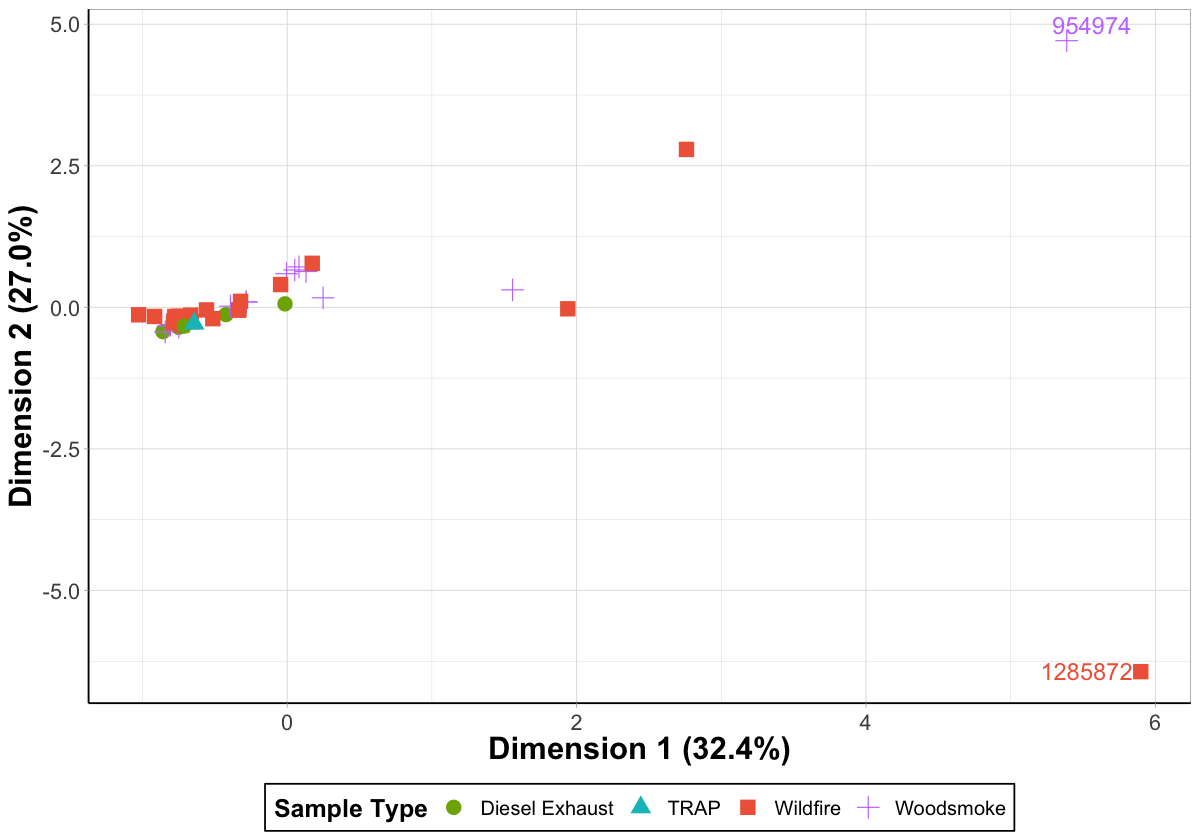

In [15]:
options(repr.plot.width=10, repr.plot.height=7) #changing size

ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Weight', Class == 'Metal'), 
       aes(x = PC1, y = PC2, color = Data, shape = Data)) + 
  geom_point(size = 4) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Weight', Class == 'Metal', PC1 > 5), 
                  aes(x = PC1, y = PC2, color = Data, label = HAWC_ID), size = 5, show.legend = FALSE) +

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (32.4%)', y = 'Dimension 2 (27.0%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c(cols[2:3], palette_colors[c(5)], cols[4])) 

## Top Metal or Chemical Contributors to PCA

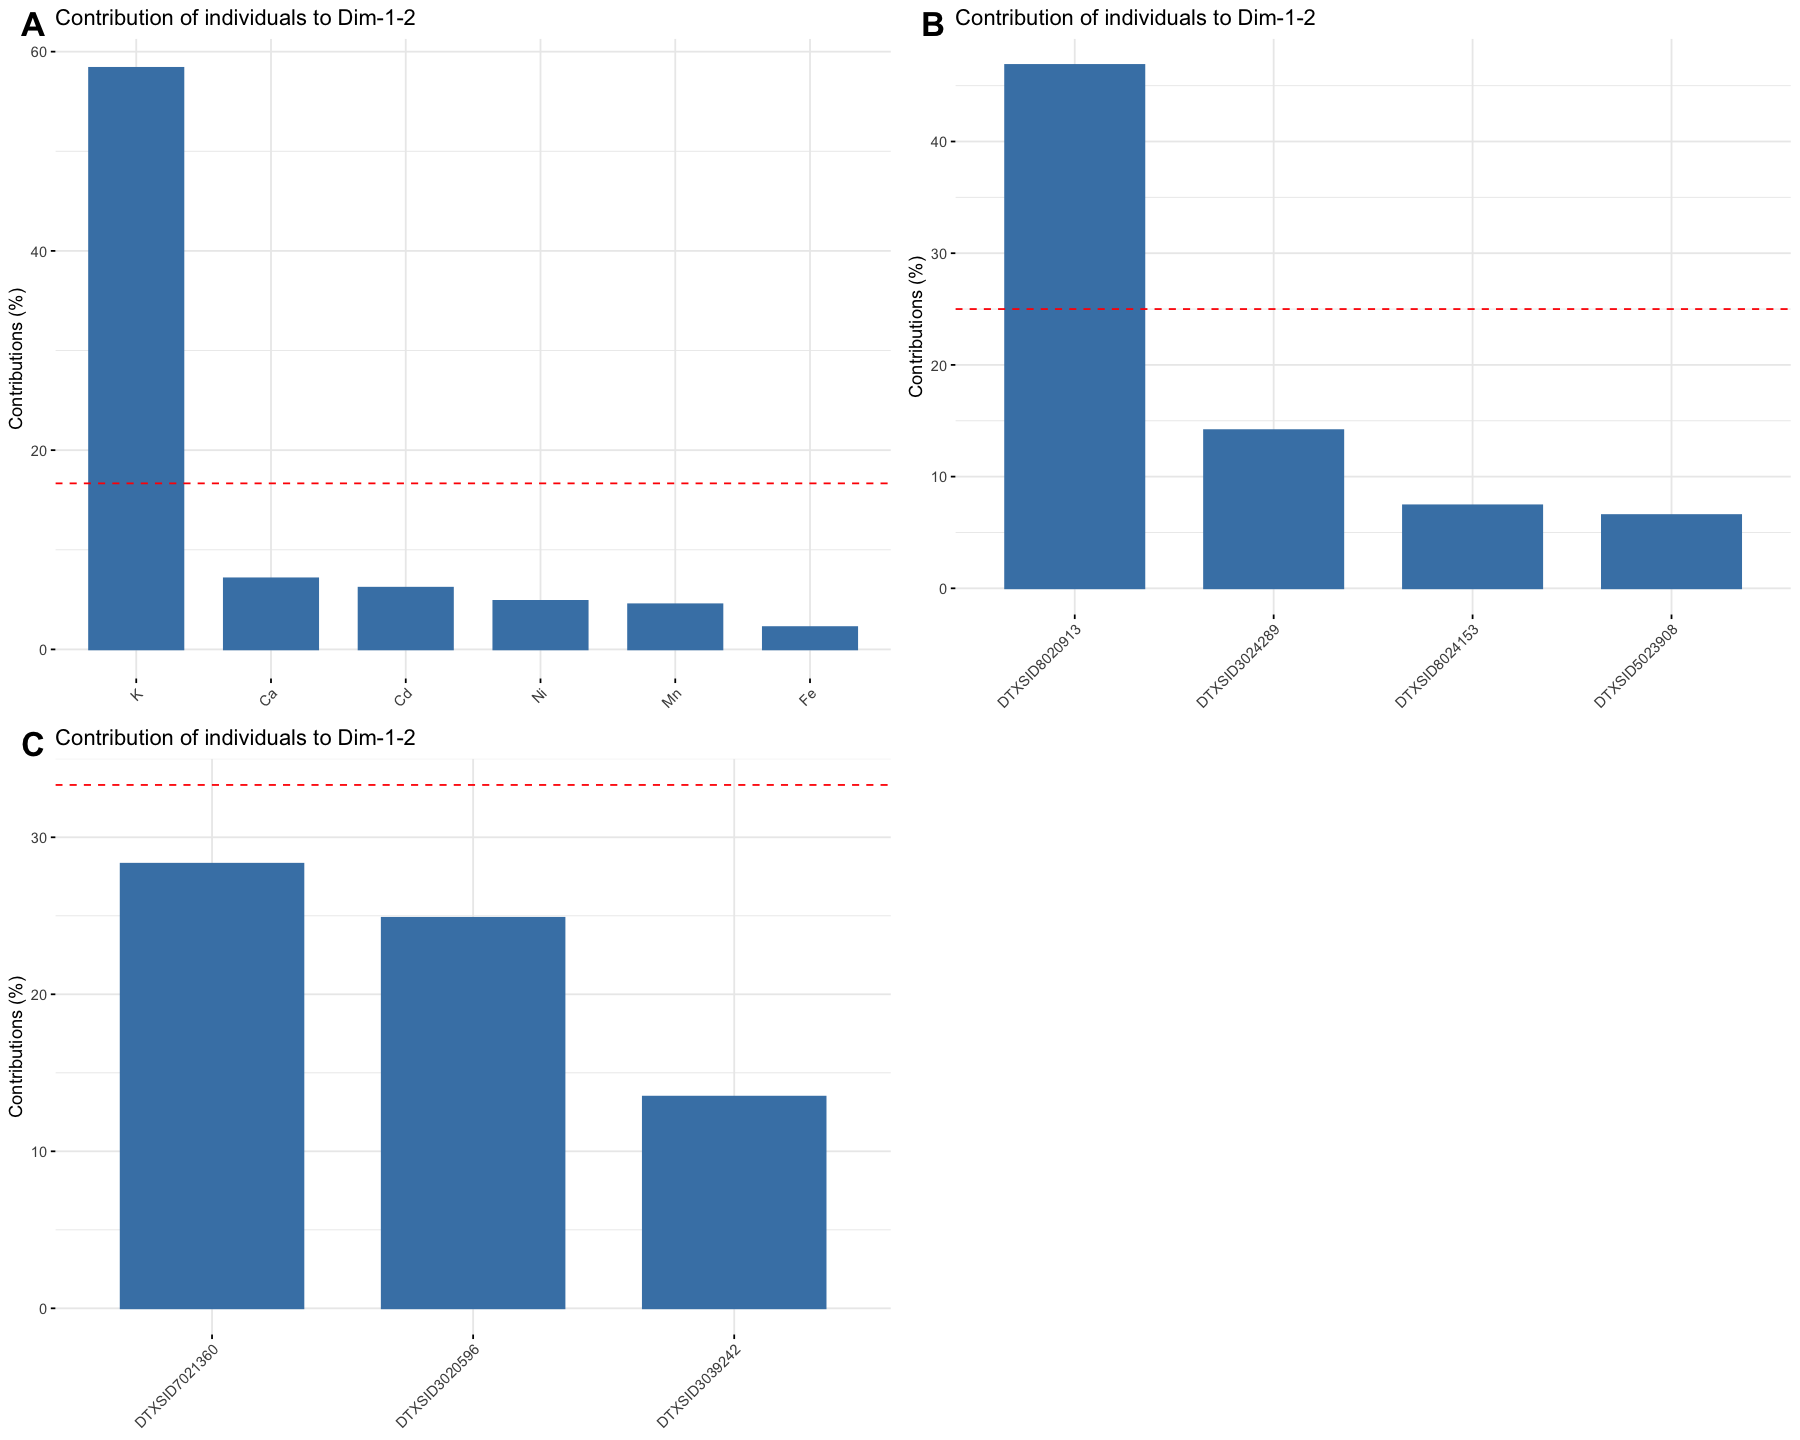

In [29]:
options(repr.plot.width=15, repr.plot.height=12) #changing size
# total contribution on PC1 and PC2
metal_vol_ind = fviz_contrib(metal_vol_pca, choice = "ind", axes = 1:2)
pah_vol_ind = fviz_contrib(pah_vol_pca, choice = "ind", axes = 1:2)
voc_vol_ind = fviz_contrib(voc_vol_pca, choice = "ind", axes = 1:2)

# combining
vol_contrib = plot_grid(metal_vol_ind, pah_vol_ind, voc_vol_ind, nrow = 2,
                            # adding labels, changing size their size and position
                            labels = "AUTO", label_size = 20, label_x = 0.01, label_y = 1)
vol_contrib

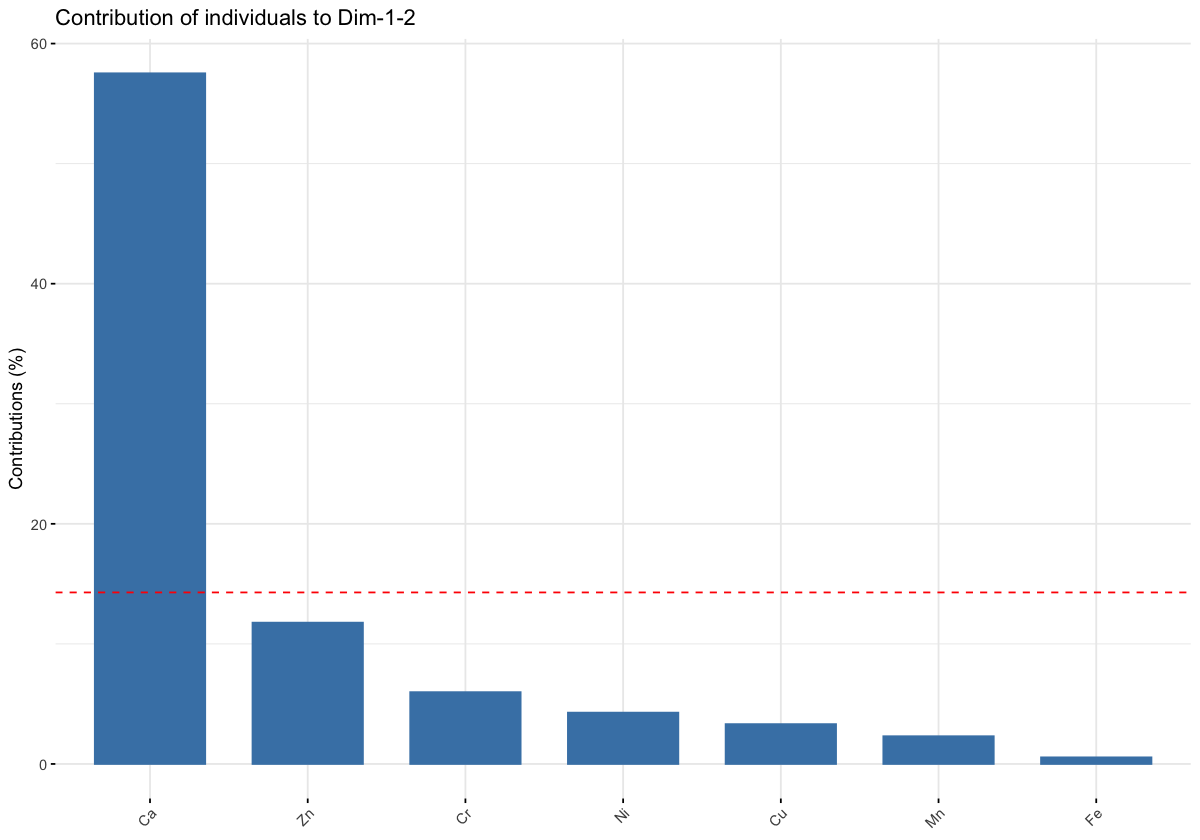

In [31]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
fviz_contrib(metal_weight_pca, choice = "ind", axes = 1:2)

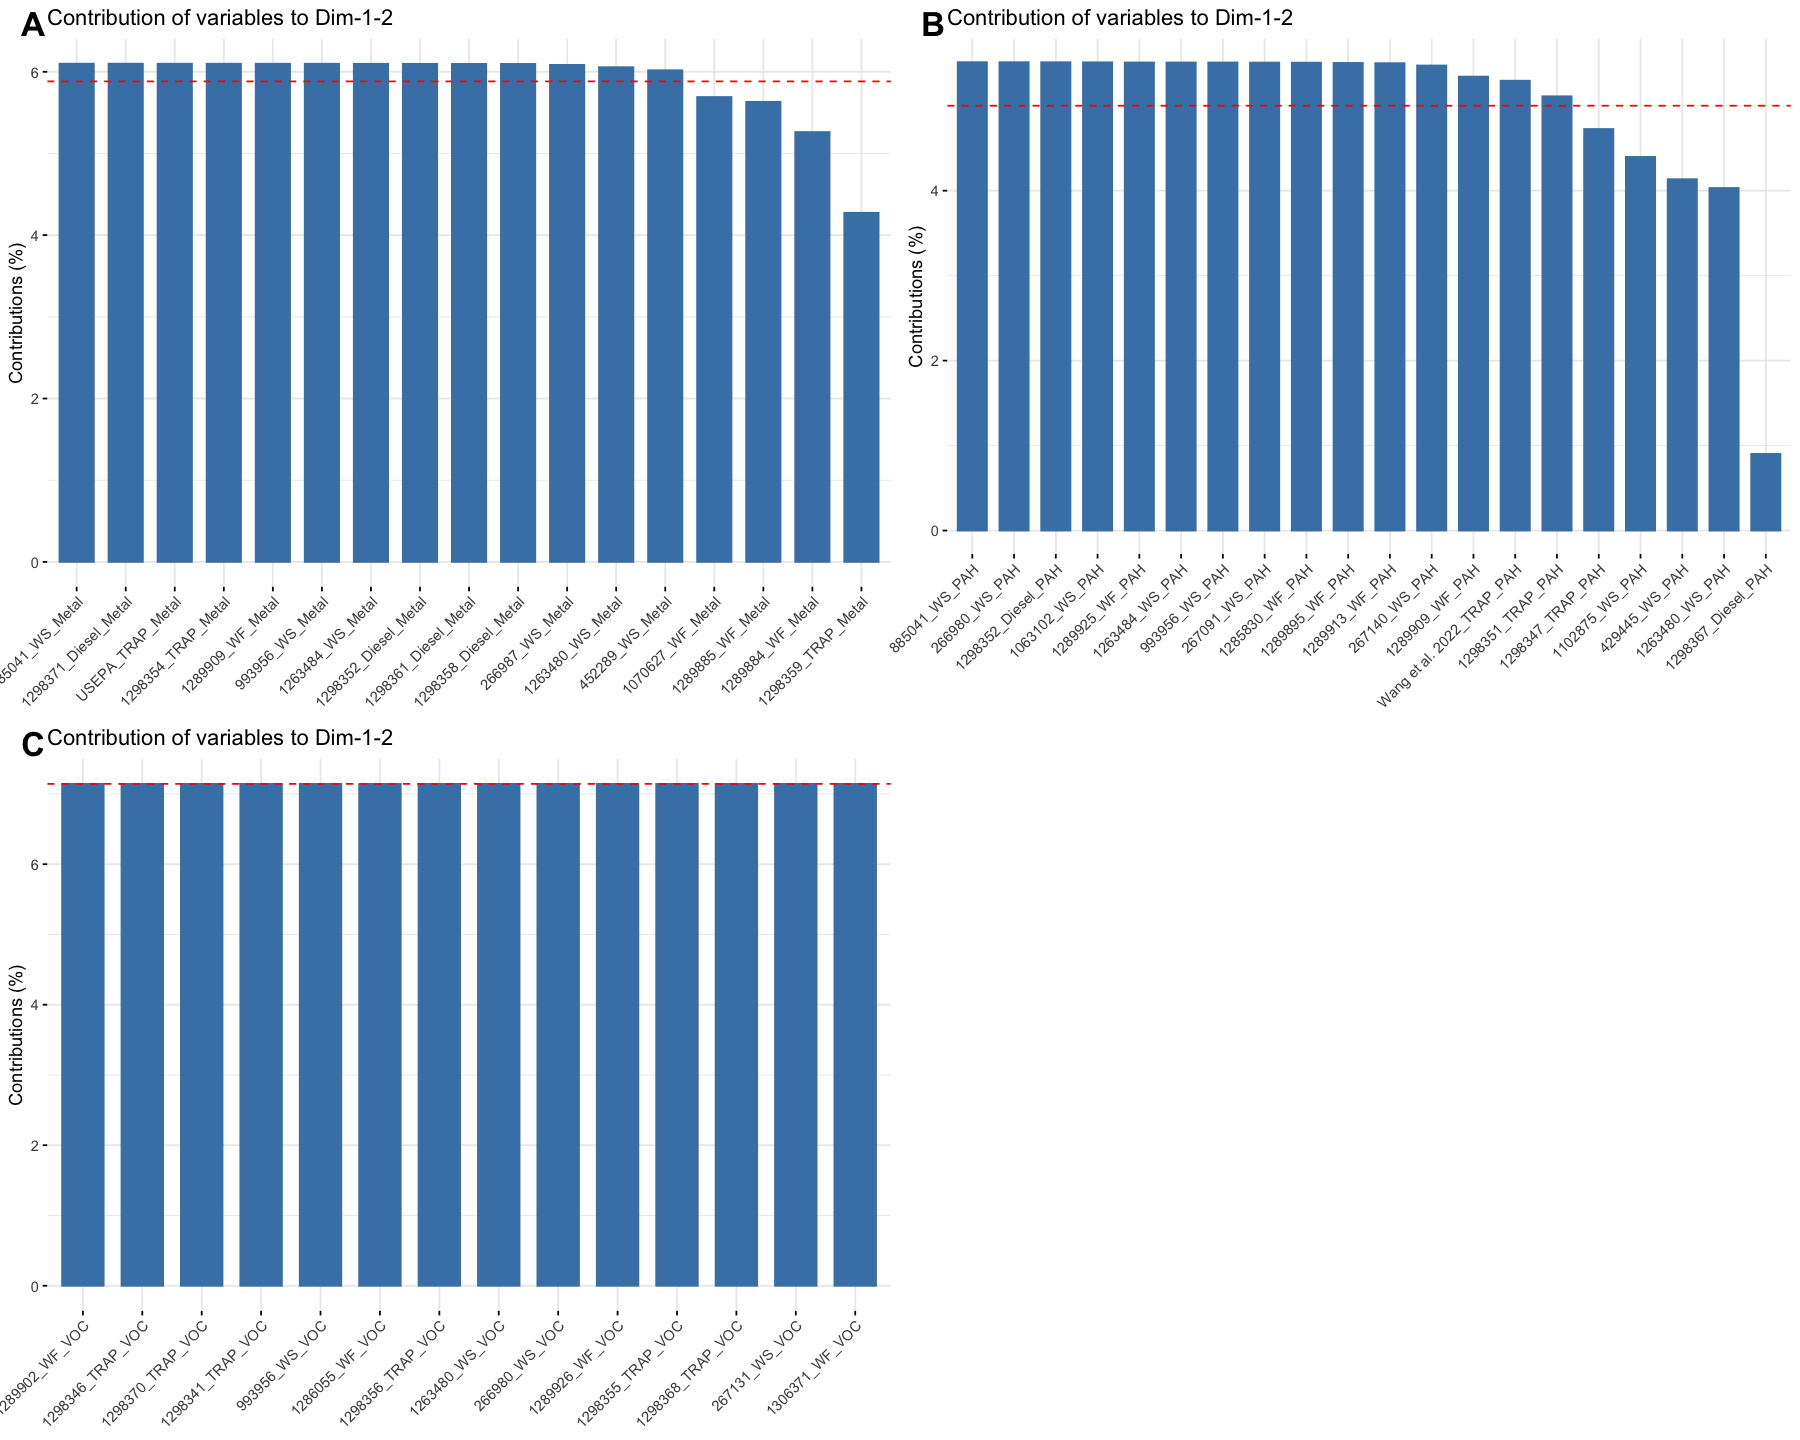

In [32]:
options(repr.plot.width=15, repr.plot.height=12) #changing size
# total contribution on PC1 and PC2
metal_vol_var = fviz_contrib(metal_vol_pca, choice = "var", axes = 1:2)
pah_vol_var = fviz_contrib(pah_vol_pca, choice = "var", axes = 1:2)
voc_vol_var = fviz_contrib(voc_vol_pca, choice = "var", axes = 1:2)

# combining
vol_var_contrib = plot_grid(metal_vol_var, pah_vol_var, voc_vol_var, nrow = 2,
                            # adding labels, changing size their size and position
                            labels = "AUTO", label_size = 20, label_x = 0.01, label_y = 1)
vol_var_contrib

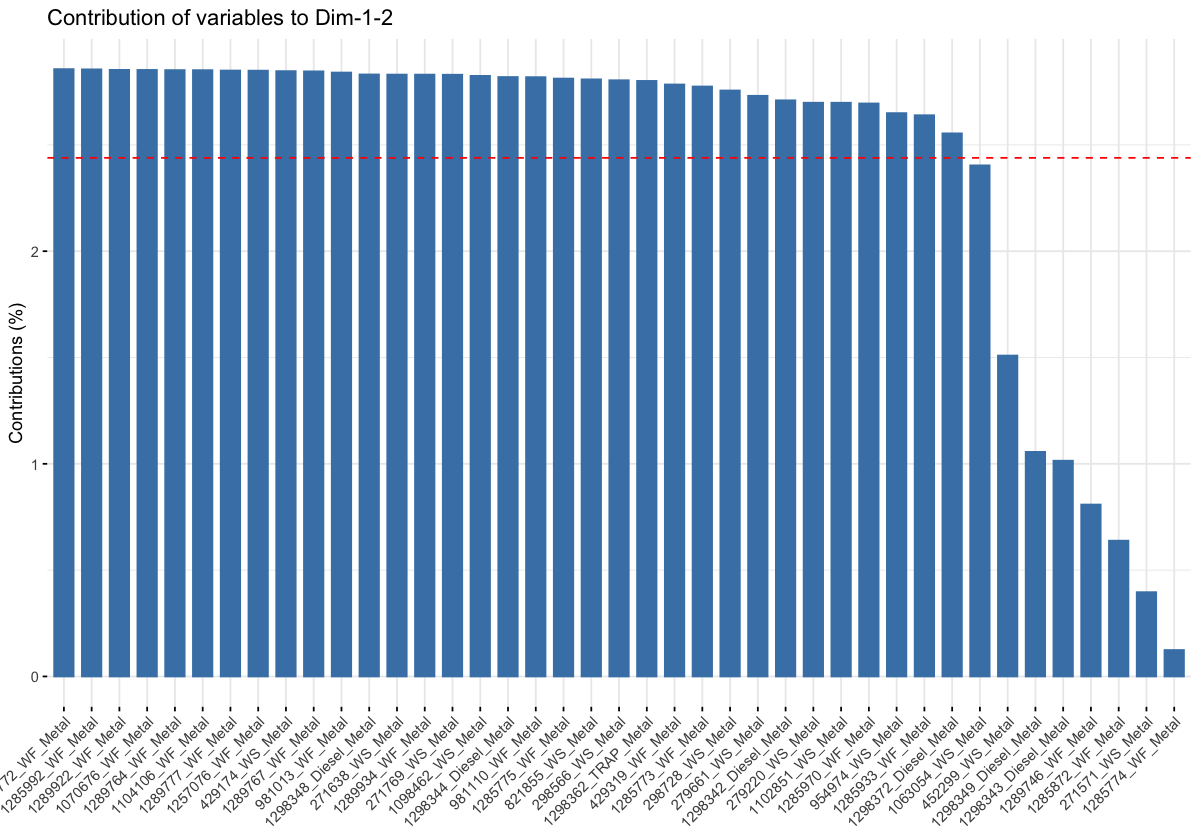

In [34]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
fviz_contrib(metal_weight_pca, choice = "var", axes = 1:2)

# PCA Version 2

In [16]:
head(t(wider_metal_vol_df[,c(6:ncol(wider_metal_vol_df))]))

,USEPA_TRAP_Metal,266987_WS_Metal,452289_WS_Metal,885041_WS_Metal,993956_WS_Metal,1263480_WS_Metal,1263484_WS_Metal,1070627_WF_Metal,1289884_WF_Metal,1289885_WF_Metal,1289909_WF_Metal,1298352_Diesel_Metal,1298354_TRAP_Metal,1298358_Diesel_Metal,1298359_TRAP_Metal,1298361_Diesel_Metal,1298371_Diesel_Metal
K,34642.92963,763600.000,82955.293,99550.00,60000,1593166.667,1730140,786.75,147241.3793,297833.333,34642.929626,34642.93,34642.9296,27928.370,99505000,123965.6389,34642.92963
Ca,512.54300,49200.000,28681.554,3710.00,2800,374250.000,61230,982.65,210071.4286,325933.333,670.000000,76.10,565.6333,1011.411,72970000,11526.0000,505.23733
Cd,0.09450,3500.000,30.000,152.00,25,1833.333,3480,5.45,1114.7308,2237.133,0.257225,0.51,0.3000,0.700,3300000,303.1883,0.05750
Fe,161.62958,52600.000,3175.101,1088.50,1400,25791.667,38670,771.00,16122.3077,52216.667,300.000000,204.00,241.4333,796.800,96850000,2021.5000,15.58750
Mn,2.17625,1800.000,290.000,133.00,280,11708.333,15885,35.55,13610.3448,27550.000,4.900000,6.40,5.7000,59.400,29510000,2102.0448,0.76825
Ni,0.73025,1538.179,170.000,25.75,47,1375.000,4200,52.20,107.7083,1600.000,1.000000,2.50,0.4000,49.900,34485000,105.8728,0.52425


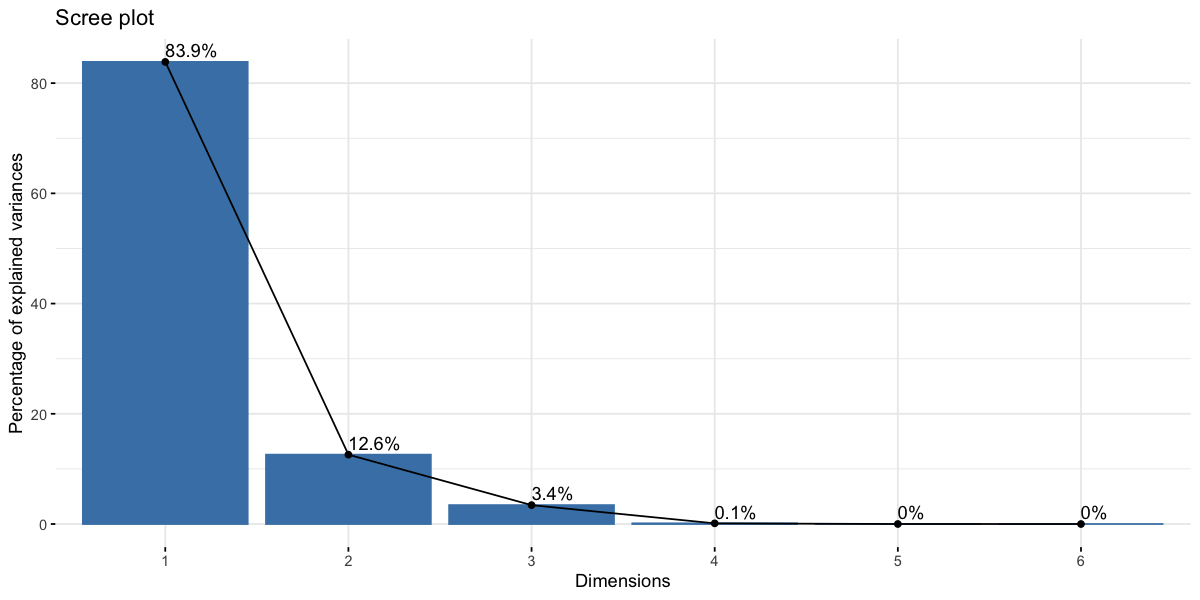

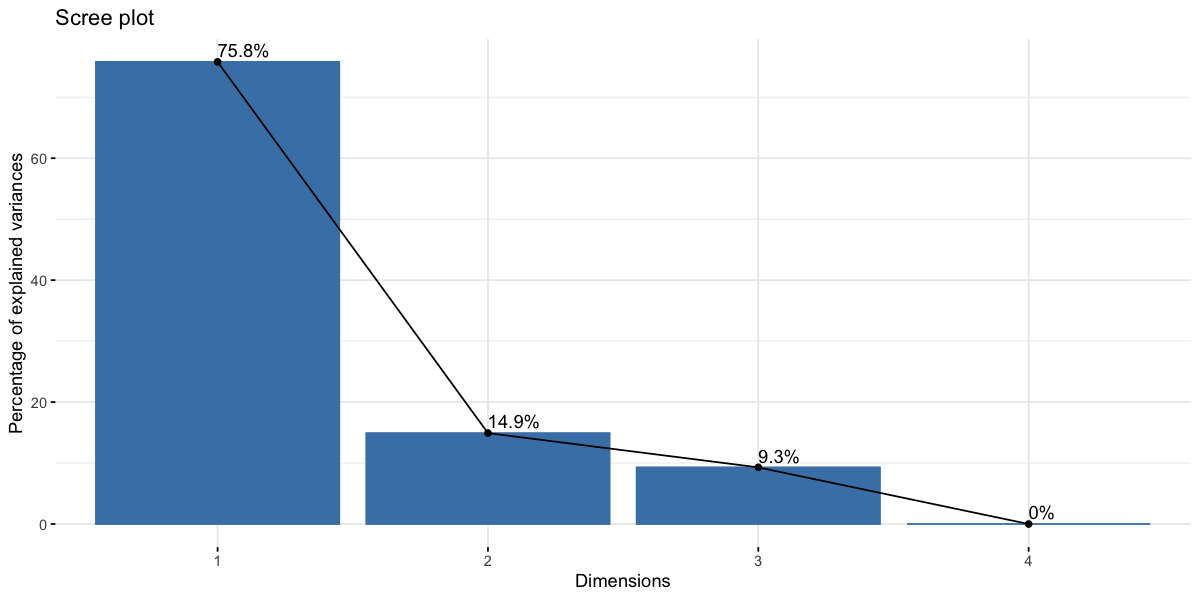

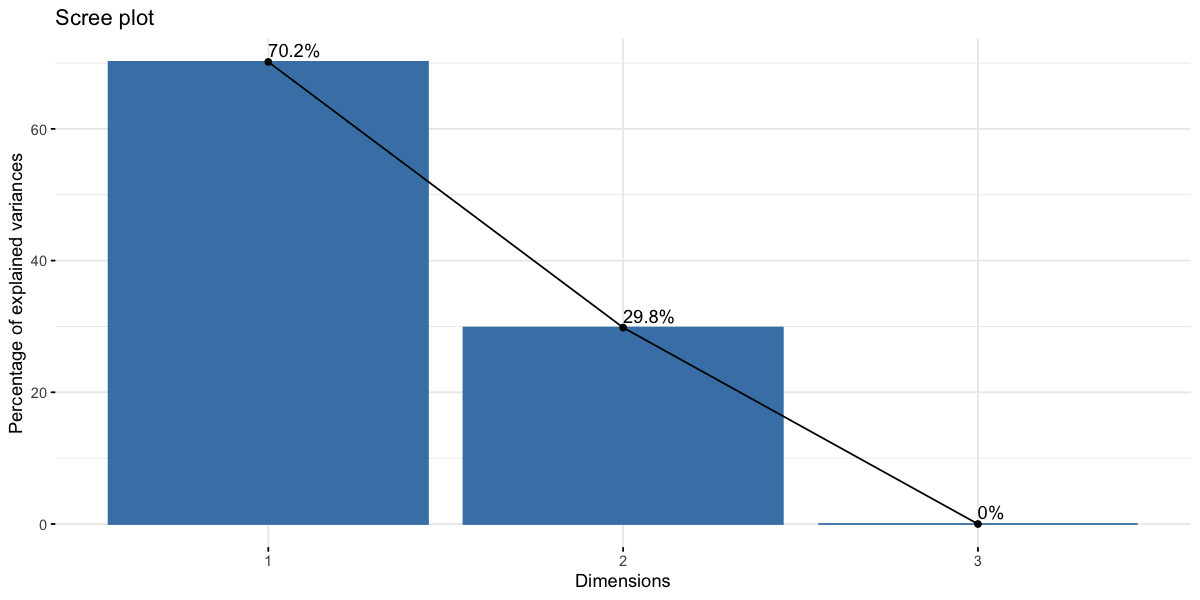

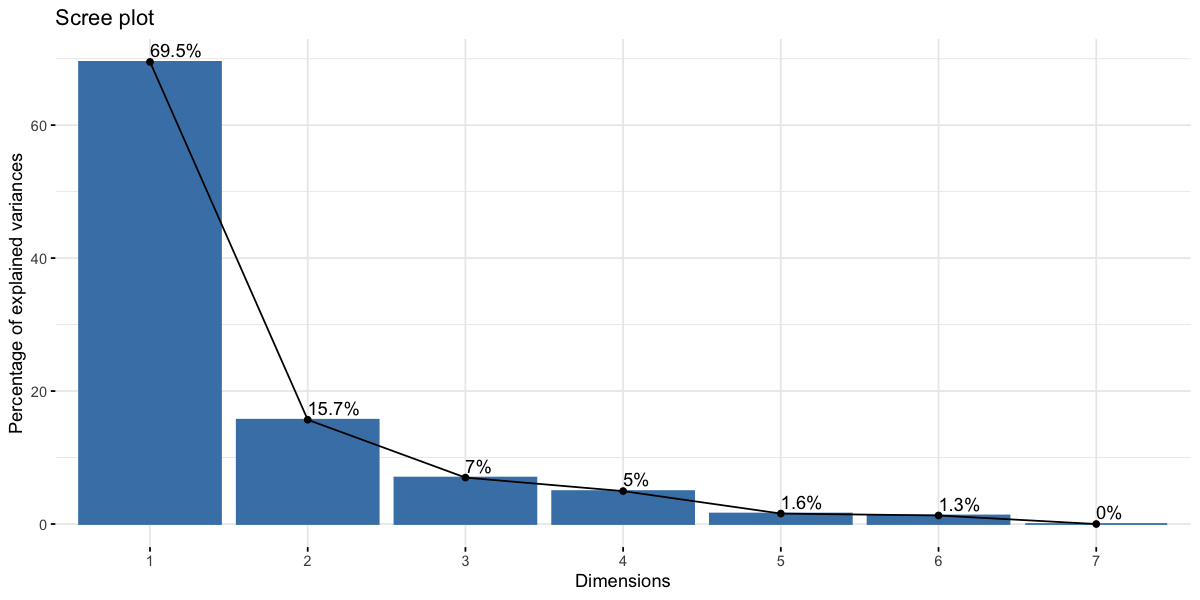

In [17]:
# running pca 
metal_vol_pca = prcomp(t(wider_metal_vol_df[,c(6:ncol(wider_metal_vol_df))]), center = TRUE, scale = TRUE)
pah_vol_pca = prcomp(t(wider_pah_vol_df[,c(6:ncol(wider_pah_vol_df))]), center = TRUE, scale = TRUE)
voc_vol_pca = prcomp(t(wider_voc_vol_df[,c(6:ncol(wider_voc_vol_df))]), center = TRUE, scale = TRUE)
metal_weight_pca = prcomp(t(wider_metal_weight_df[,c(6:ncol(wider_metal_weight_df))]), center = TRUE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(metal_vol_pca, addlabels = TRUE)
fviz_eig(pah_vol_pca, addlabels = TRUE)
fviz_eig(voc_vol_pca, addlabels = TRUE)
fviz_eig(metal_weight_pca, addlabels = TRUE)
#fviz_eig(cytokine_pca, addlabels = TRUE)

In [18]:
metal_vol_pca_df = data.frame(metal_vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
pah_vol_pca_df = data.frame(pah_vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
voc_vol_pca_df = data.frame(voc_vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
metal_weight_pca_df = data.frame(metal_weight_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")    

In [19]:
v2_df = rbind(metal_vol_pca_df, pah_vol_pca_df,
                                       voc_vol_pca_df, metal_weight_pca_df) 
v2_df

SampleID,PC1,PC2
<chr>,<dbl>,<dbl>
K,-7.5547730,0.5891650
Ca,0.1514191,-2.6444941
Cd,2.1615626,1.1910637
Fe,1.2665696,-0.7725858
Mn,1.9607181,0.7814803
Ni,2.0145036,0.8553709
DTXSID3024289,-2.1849401,2.3453803
DTXSID5023908,-2.0225099,-0.8170499
DTXSID8024153,-1.6219368,-1.6616180


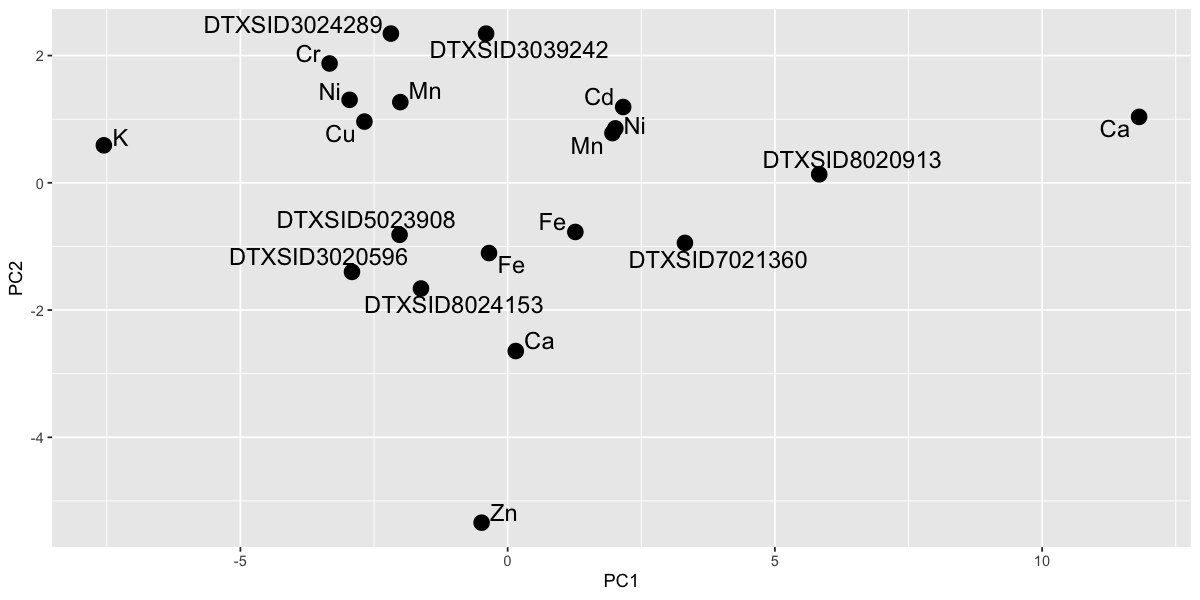

In [20]:
ggplot(data = v2_df, 
       aes(x = PC1, y = PC2)) + 
geom_text_repel(aes(label = SampleID), size = 5) + 
  geom_point(size = 4)

In [21]:
loadings_df = data.frame(metal_vol_pca$rotation) %>%
  rownames_to_column(var = "Cytokine") %>%
  select(Cytokine, PC1, PC2) %>%
  pivot_longer(cols = c("PC1", "PC2"), names_to = "PC", values_to = "Loading") %>%
  # adding an additional bogus col for the later heat map to work
    mutate(Category = "Cytokine")

head(loadings_df)

Cytokine,PC,Loading,Category
<chr>,<chr>,<dbl>,<chr>
USEPA_TRAP_Metal,PC1,-0.26033275,Cytokine
USEPA_TRAP_Metal,PC2,0.12560622,Cytokine
266987_WS_Metal,PC1,-0.26232953,Cytokine
266987_WS_Metal,PC2,0.08800328,Cytokine
452289_WS_Metal,PC1,-0.26118812,Cytokine
452289_WS_Metal,PC2,-0.08179445,Cytokine


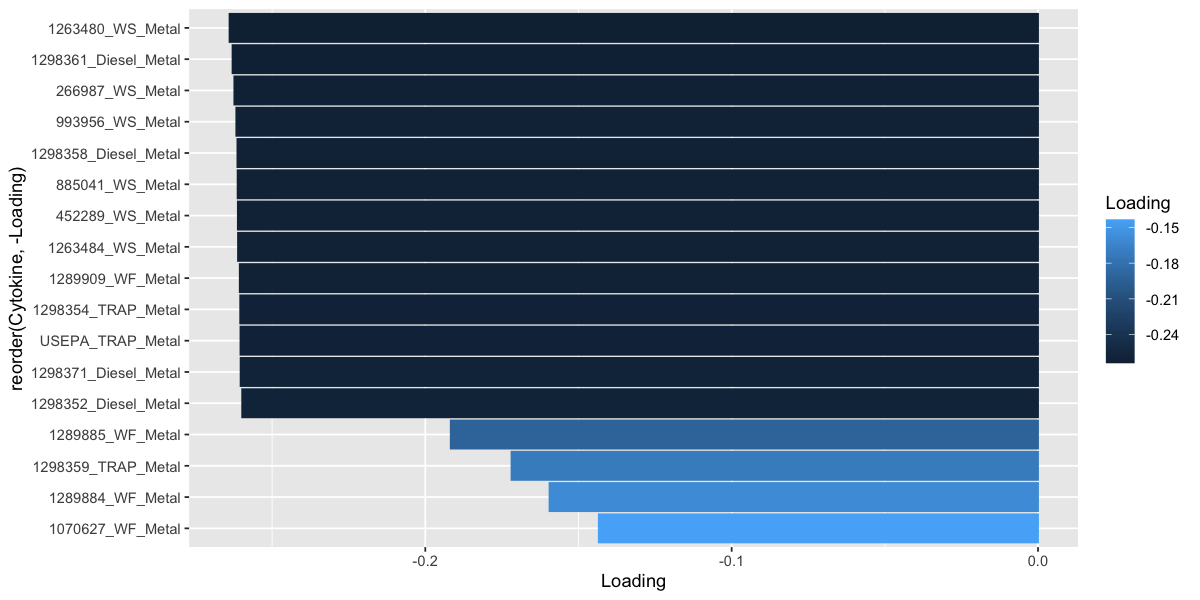

In [22]:
ggplot(loadings_df %>%
    #filtering for PC1 
    filter(PC == "PC1"), 
       aes(y = reorder(Cytokine, -Loading), x = Loading, color = Loading, fill = Loading)) + 
  geom_bar(stat = "identity")

# bcpa

In [5]:
head(metal_vol_df)

HAWC_ID,Metric,Data,Study,Class,DTXSID,Name,Avg_Value
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1298351,Volume,TRAP,Gunawardena et al. 2012,Metal,Cr,Cr,28.78885
1298351,Volume,TRAP,Gunawardena et al. 2012,Metal,Cu,Cu,13.30890
USEPA,Volume,TRAP,USEPA,Metal,Cu,Cu,NA
1070627,Volume,WF,Siregar et al. 2022,Metal,As,As,1.55000
1070627,Volume,WF,Siregar et al. 2022,Metal,Ca,Ca,982.65000
1070627,Volume,WF,Siregar et al. 2022,Metal,Cd,Cd,5.45000


In [7]:
t_df = metal_vol_df %>%
    # creating sample ids
    unite("SampleID", c(colnames(metal_vol_df)[c(6,5,3)]), remove = FALSE) %>%
    select(-Study) %>%
    pivot_wider(names_from = "HAWC_ID", values_from = "Avg_Value") %>%
    column_to_rownames(var = "SampleID")

head(t_df)

,Metric,Data,Class,DTXSID,Name,1298351,USEPA,1070627,1263480,1263484,⋯,1298354,1298358,1298359,1298361,1298371,266980,266987,452289,885041,993956
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cr_Metal_TRAP,Volume,TRAP,Metal,Cr,Cr,28.78885,3.91325,NA,NA,NA,⋯,1.266667,NA,83820000,NA,NA,NA,NA,NA,NA,NA
Cu_Metal_TRAP,Volume,TRAP,Metal,Cu,Cu,13.30890,NA,NA,NA,NA,⋯,11.933333,NA,25515000,NA,NA,NA,NA,NA,NA,NA
As_Metal_WF,Volume,WF,Metal,As,As,NA,NA,1.55,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Ca_Metal_WF,Volume,WF,Metal,Ca,Ca,NA,NA,982.65,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Cd_Metal_WF,Volume,WF,Metal,Cd,Cd,NA,NA,5.45,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Co_Metal_WF,Volume,WF,Metal,Co,Co,NA,NA,4.90,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [12]:
bpca = pca(wider_metal_vol_df[,c(6:ncol(wider_metal_vol_df))], method = 'bpca')
bpca_scores <- data.frame(bpca@scores) 

Warning message:
“Removed 17 rows containing missing values (`geom_path()`).”


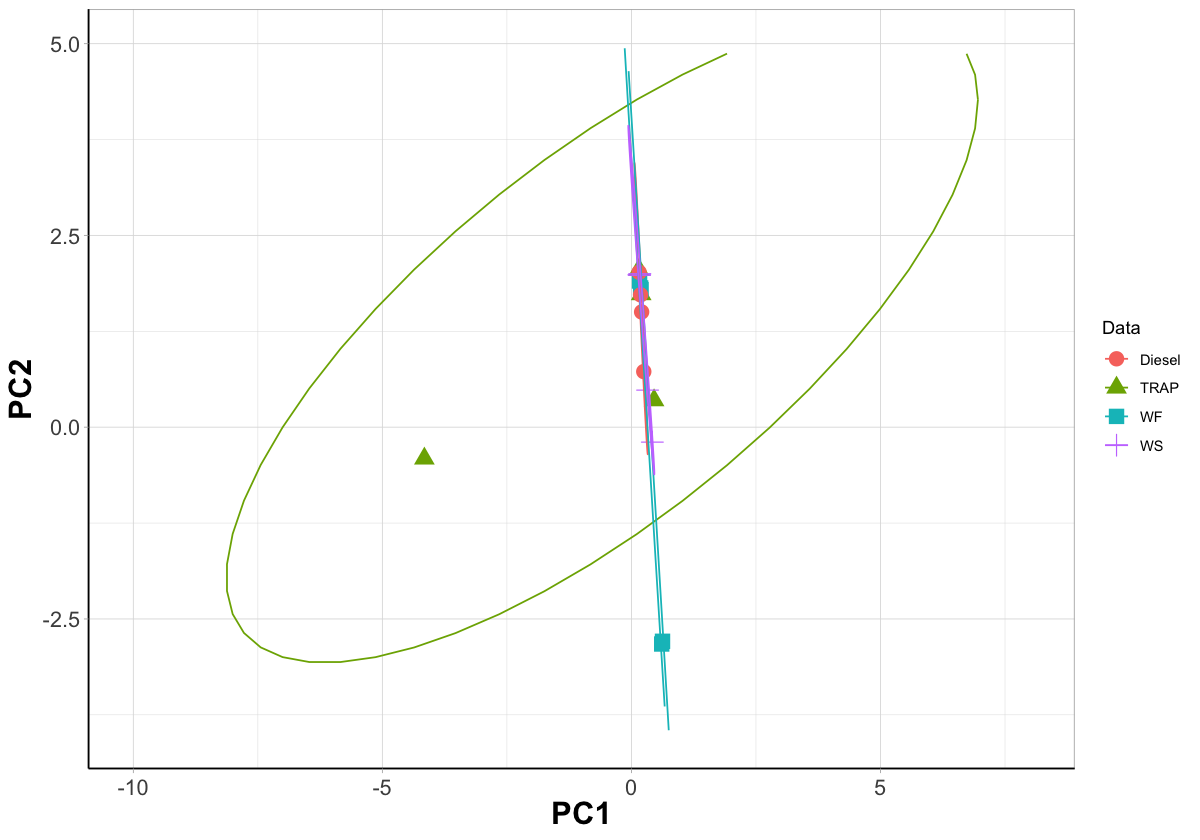

In [14]:
# Determine if there are any outliers > 6 SD from the mean
bpca_outliers <- apply(bpca_scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)

# Get percentage contribution to each axis
bpca_loadings <- data.frame(bpca@R2)

options(repr.plot.width=10, repr.plot.height=7) #changing size
bpca_plot <- ggplot(cbind(wider_metal_vol_df[,1:5], bpca_scores), aes(x = PC1, y = PC2,color = Data, shape = Data)) + 
  geom_point(size = 4) + 
  stat_ellipse(level = 0.95) + # 95% confidence ellipses
  ylim(-4, 5) + # changes the limits of the y axis 
  xlim(-10, 8) + # changes the limits of the y axis 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold"))# + #changes size of facet y axis 
  #labs(x = 'Dimension 1 (36.8%)', y = 'Dimension 2 (24.6%)') #changing axis labels
     

bpca_plot

In [10]:
cbind(t_df[,1:5], bpca_scores)

,Metric,Data,Class,DTXSID,Name,PC1,PC2
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Cr_Metal_TRAP,Volume,TRAP,Metal,Cr,Cr,-1.665407e-02,4.432886e-16
Cu_Metal_TRAP,Volume,TRAP,Metal,Cu,Cu,1.462841e+00,-3.893674e-14
As_Metal_WF,Volume,WF,Metal,As,As,3.894297e-23,4.224821e-10
Ca_Metal_WF,Volume,WF,Metal,Ca,Ca,-3.406701e-22,-3.695842e-09
Cd_Metal_WF,Volume,WF,Metal,Cd,Cd,5.290934e-28,5.739992e-15
Co_Metal_WF,Volume,WF,Metal,Co,Co,7.869639e-23,8.537569e-10
Fe_Metal_WF,Volume,WF,Metal,Fe,Fe,2.133480e-23,2.314557e-10
K_Metal_WF,Volume,WF,Metal,K,K,-2.806164e-22,-3.044335e-09
Li_Metal_WF,Volume,WF,Metal,Li,Li,5.409884e-28,5.869037e-15
